In [1]:
import time
times = []
Beginning = time.time()

In [2]:
import re, pandas as pd, numpy as np
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from pandarallel import pandarallel
from nltk.stem.isri import ISRIStemmer
import os
import stanza
import matplotlib.pyplot as plt
from gensim.models import Word2Vec, FastText

In [3]:
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\Saad\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [4]:
# n_workers = max(1, os.cpu_count() // 4)
n_workers = 3
pandarallel.initialize(nb_workers=n_workers, progress_bar=True)
print(f"\nUsing {n_workers} cores for parallel processing")

INFO: Pandarallel will run on 3 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/

Using 3 cores for parallel processing


In [5]:
TARGET = 500
MinimumArabicPercentage = 0.4

print('Loading data …')
df = pd.read_csv('arabic_sentiment_reviews.csv', encoding='utf-8', nrows=TARGET)
print(f'Loaded {len(df):,} rows')

Loading data …
Loaded 500 rows


In [6]:
def arabic_ratio(text: str) -> float:
    if not isinstance(text, str) or not text.strip():
        return 0.0
    arabic_len = sum(1 for ch in text if '\u0600' <= ch <= '\u06FF')
    return arabic_len / max(len(text), 1)

In [7]:
print('Applying Arabic-ratio filter …')
df['arabic_ratio'] = df['content'].apply(arabic_ratio)
print(f'Kept {len(df):,} rows after filter')

Applying Arabic-ratio filter …
Kept 500 rows after filter


In [8]:
def clean_arabic_text(text: str) -> str:
    if not isinstance(text, str):
        return ''
    text = re.sub(r'[^\w\s\u0600-\u06FF]', ' ', text)   # drop non-Arabic
    text = re.sub(r'\\s+', ' ', text).strip()
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ي", text)
    text = re.sub("ء", "", text)   # drop hamza
    text = re.sub(r'(.)\\1{2,}', r'\\1\\1', text)
    return text

In [9]:
def get_char_ngrams(text: str, n: int) -> str:
    """Generate space‑separated character n‑grams from cleaned text."""
    if not isinstance(text, str) or not text.strip():
        return ''
    
    # Re‑use the same cleaning logic for consistency
    cleaned = clean_arabic_text(text)
    
    # Skip if cleaned text is shorter than n
    if len(cleaned) < n:
        return ''
    
    # Sliding‑window n‑grams
    ngrams = [cleaned[i:i+n] for i in range(len(cleaned) - n + 1)]
    return ' '.join(ngrams)

In [10]:
print('Generating character 3‑grams and 4‑grams (non‑parallel) …')
start = time.time()
df['char_3grams'] = df['content'].apply(lambda x: get_char_ngrams(x, 3))
df['char_4grams'] = df['content'].apply(lambda x: get_char_ngrams(x, 4))
elapsed = time.time() - start
times.append([" Caharacter n- grams: ", elapsed])
print(f'Character n‑grams generated in {elapsed:.1f} s')

def light_stem(txt: str) -> str:
    import re
    from nltk.tokenize import word_tokenize
    from nltk.stem.isri import ISRIStemmer  # ← import here
    stemmer = ISRIStemmer()                 # ← instantiate here

    if not isinstance(txt, str) or not txt.strip():
        return ''
    txt = re.sub(r'[^\w\s\u0600-\u06FF]', ' ', txt)   # drop non-Arabic
    txt = re.sub(r'\\s+', ' ', txt).strip()
    txt = re.sub("[إأٱآا]", "ا", txt)
    txt = re.sub("ة", "ه", txt)
    txt = re.sub("ى", "ي", txt)
    txt = re.sub("ؤ", "و", txt)
    txt = re.sub("ئ", "ي", txt)
    txt = re.sub("ء", "", txt)   # drop hamza
    txt = re.sub(r'(.)\\1{2,}', r'\\1\\1', txt)

    tokens = word_tokenize(txt)
    
    stems = [stemmer.stem(token) for token in tokens]

    return ' '.join(stems)

Generating character 3‑grams and 4‑grams (non‑parallel) …
Character n‑grams generated in 0.1 s


In [11]:
start = time.time()
df['text_stem'] = df['content'].parallel_apply(light_stem)
elapsed = time.time() - start
times.append([" Stemming ISRI: ", elapsed])
print(f'Stemming finished in {elapsed:.1f} s  ({len(df):,} rows)')

Stemming finished in 2.2 s  (500 rows)


In [12]:
print("Warming up Stanza pipeline in main process (this may take a minute)...")
_ = stanza.Pipeline('ar', processors='tokenize,pos')
print("✅ Stanza pipeline warm-up complete.")

2025-11-28 22:13:07 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


Warming up Stanza pipeline in main process (this may take a minute)...


2025-11-28 22:13:09 INFO: Downloaded file to C:\Users\Saad\stanza_resources\resources.json
2025-11-28 22:13:09 WARNING: Language ar package default expects mwt, which has been added
2025-11-28 22:13:10 INFO: Loading these models for language: ar (Arabic):
| Processor | Package     |
---------------------------
| tokenize  | padt        |
| mwt       | padt        |
| pos       | padt_charlm |

2025-11-28 22:13:10 INFO: Using device: cpu
2025-11-28 22:13:10 INFO: Loading: tokenize
2025-11-28 22:13:11 INFO: Loading: mwt
2025-11-28 22:13:11 INFO: Loading: pos
2025-11-28 22:13:12 INFO: Done loading processors!


✅ Stanza pipeline warm-up complete.


In [13]:
def tag_record_stanza_parallel(text: str) -> str:
   
    if 'stanza_nlp_pipeline' not in globals():
        
        import stanza  
        
        globals()['stanza_nlp_pipeline'] = stanza.Pipeline(
            'ar', processors='tokenize,pos', verbose=False
        )
    
    # Access the pipeline from the worker's global scope
    nlp = globals()['stanza_nlp_pipeline']
    
    if not isinstance(text, str) or not text.strip():
        return ''
    
    doc = nlp(text)
    
    tok_pos_list = []
    for sent in doc.sentences:
        for word in sent.words:
            tok_pos_list.append(f'{word.text}_{word.upos}')
    
    
    return '|'.join(tok_pos_list)

In [14]:
print("Starting parallel POS-tagging...")
start = time.time()
df['pos_tags'] = df['content'].parallel_apply(tag_record_stanza_parallel)
elapsed = time.time() - start
times.append([" Tagging Stanza: ", elapsed])
print(f'Tagging finished in {elapsed:.1f} s')

label_counts = df['label'].value_counts()

Starting parallel POS-tagging...


Tagging finished in 75.3 s


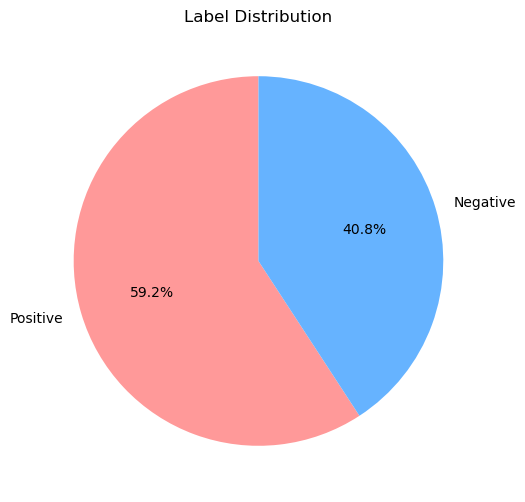

In [15]:
# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    label_counts,
    labels=label_counts.index.map({0: 'Negative', 1: 'Positive'}),  # optional label names
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff9999', '#66b3ff']  # optional colors
)

plt.title('Label Distribution')
plt.show()

In [16]:
print("Preparing corpus for embedding training...")
corpus = df['text_stem'].apply(lambda x: x.split() if isinstance(x, str) else []).tolist()

Preparing corpus for embedding training...


In [17]:
print("Training Word2Vec model...")
w2v_model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=n_workers, sg=1)  # sg=1 for Skip-gram
w2v_model.save("arabic_w2v.model")
print("Word2Vec model saved.")

Training Word2Vec model...
Word2Vec model saved.


In [18]:
print("Training FastText model...")
ft_model = FastText(corpus, vector_size=100, window=5, min_count=1, workers=n_workers)
ft_model.save("arabic_ft.model")
print("FastText model saved.")

Training FastText model...
FastText model saved.


In [19]:
# Function to get average embedding for a review (using FastText as example; switch to w2v_model if preferred)
def get_average_embedding(text: str) -> str:
    import numpy as np
    from gensim.models import FastText
    model = FastText.load('arabic_ft.model')
    if not isinstance(text, str) or not text.strip():
        return ''  # Empty string for no embedding
    
    tokens = text.split()
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    
    if not vectors:
        return ''  # No valid words
    
    avg_vec = np.mean(vectors, axis=0)
    return ' '.join(f"{v:.6f}" for v in avg_vec)  # Serialize as space-separated floats

In [20]:
print("Computing average embeddings (parallel)...")
start = time.time()
df['average_embedding'] = df['text_stem'].parallel_apply(get_average_embedding)
elapsed = time.time() - start
times.append([" Average Embeddings: ", elapsed])
print(f'Average embeddings computed in {elapsed:.1f} s')

Computing average embeddings (parallel)...


Average embeddings computed in 86.4 s


In [21]:
# Save the final DataFrame
out_file = 'arabic_gensim_reviews.csv'
df.to_csv(out_file, index=False, encoding='utf-8')
print(f'Saved → {out_file}  ({len(df):,} rows)')

Saved → arabic_gensim_reviews.csv  (500 rows)


In [22]:
Final = time.time()
times.append(["Overall", Final - Beginning])

In [23]:
print(f"n_rows: {TARGET}\n")
print("Times for POS_Tagging Processing")
for i in times:
    print(f"⏱️ {i[0]} : {i[1]:.6} seconds")

n_rows: 500

Times for POS_Tagging Processing
⏱️  Caharacter n- grams:  : 0.0626061 seconds
⏱️  Stemming ISRI:  : 2.17314 seconds
⏱️  Tagging Stanza:  : 75.2613 seconds
⏱️  Average Embeddings:  : 86.4309 seconds
⏱️ Overall : 360.189 seconds
